# Advection-Diffusion-IBVP

This notebook implements the BCGP and UCGP experiments for Adv-Diff-IBVP from Section 5.5 of the manuscript. Note that the experiments in the paper involved differerent datasets under multiple random regenerations - for simplicity, however, here we provide only one dataset

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ['JAX_PLATFORM_NAME'] = 'cpu'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random, devices

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append('../../')

import jax_pigp
from jax_pigp.utility_fns import softplus, generate_params, PARAM_OPTIONS_DICT as param_gen_options
from jax_pigp.base import Callable, Array

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True) 
config.update("jax_debug_nans", False) 

Check what devices are available

In [3]:
devices()

[CudaDevice(id=0)]

### Specify settings of the experiments

In [4]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 98171

# true value of the pde parameter theta 
THETA_TRUE: Array  = jnp.array([.05, 0.025])

# bounds from which to randomly sample initial value of theta
THETA_BOUNDS: Array = jnp.array([[0.25, 0.5],
                                 [1.00, 2.00]])

# Set to True to consider inverse problem of identifying theta
RUN_INVERSE: bool = True

# specify how GP handles boundary conditions 
GP_TYPE = 'bcgp'
assert GP_TYPE in ['bcgp', 'ucgp'] 

# number of u/f space observations to use for inference
N_DATA: int = 25
Nu: int = N_DATA
Nf: int = N_DATA

# path to subdirectory in /data where Heat-IBVP-1 data is saved
data_save_dir: str = f'advectionDiffusion'
data_save_dir_full = os.path.join('data', data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 2

# initial value for std of noise levels for u/f points
NOISE_INIT = jnp.array([0.1]*2)

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = True

# options for model training
N_TRAIN_STEPS: int = 25000
N_RESTARTS: int    = 3
LR_INIT: float     = 0.025
VERBOSE: bool      = False

### Specify boundary-constrained mean and kernel functions

The BCGP mean $(\tilde{m})$ and kernel $(\tilde{k})$ functions are presented in Appendix B.2.7 of the manuscript, and they are designed to ensure that the BCGP exactly satisfies the Dirichlet initial condition at $t=0$ and Dirichlet boundary conditions for $x \in \partial \Omega =  \{0,1\}$. These functions take the form

 \begin{align*} 
 \tilde{m}(x,t) = & \; \sin(2\pi x) \exp(x),  \\
 \tilde{k}([x,t], [x',t']) = &\; \phi(x,t)\phi(x',t')k([x,t], [x',t']),
 \end{align*}

where the ADF $\phi$ is given by

\begin{equation*}
\phi(x,t)  = x(1-x)t
\end{equation*}

The above equations are implemented as follows: 

In [5]:
BASE_KERNEL = jax_pigp.kernels.squared_exponential

if GP_TYPE == "bcgp":
    print(f'using boundary constrained mean and kernel')
    
    def phi(loc: Array):
        x, t = loc 
        # here we scale the output by 8 so that the max 
        # value of phi over the spatio-temporal domain
        # is equal to one
        return 8. * x * (1.-x) * t
    
    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        k_params = params['kernel_params_1']
        base_kernel_val = BASE_KERNEL(k_params, loc1, loc2)
    
        cov_val = phi(loc1)*phi(loc2)*base_kernel_val
    
        return cov_val.squeeze()
    
    def mean_fn(params: dict, loc: Array):
        x, _ = loc 
        return jnp.sin(2.*jnp.pi*x) * jnp.exp(x)
    
else:
    print(f'using unconstrained mean and kernel')
    
    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        k_params = params['kernel_params_1']
    
        return BASE_KERNEL(k_params, loc1, loc2)
    
    mean_fn= lambda p, loc: loc[0]*0.

using boundary constrained mean and kernel


### Specify advection-diffusion differential operator

The advection-diffusion PDE over one spatial dimension takes the form

$$\mathcal{L}_{x,t}^{\boldsymbol{\theta}}[u] =   \frac{\partial u}{\partial t} + \theta_1 \frac{\partial u}{\partial x} - \theta_2 \frac{\partial^2 u}{\partial x^2} = f = 0,$$
where $\theta_1$ controls the strength of the advection term, and $\theta_2$ controls the level of diffusion.

Note there is a slight typo here in Eq.(64) of the manuscript.

##### Implementation: 

* We define a dummy linear operator for $u$-space data which is just the identity transformation
* $f$ is returned by calling the ``apply_PDE`` function defined below


In [6]:
def apply_Identity(fn: Callable,argnum: int = 1):
    return fn

def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the advection-diffusion PDE to input fn at specified argnum
    """

    # the Jacobian and Hessian functions    
    Jfn, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial value comes before temporal value in loc1 and loc2
        
        theta_1, theta_2 = THETA_TRANSFORM(params['theta']) if RUN_INVERSE else THETA_TRUE

        # first derivatives are the elements of the Jacobian vector
        ux_val, ut_val = Jfn(params, loc1, *loc2)
            
        # second spatial derivative is upper left element of the Hessian matrix
        uxx_val = Hfn(params, loc1, *loc2)[0,0]
        
        return_val = ut_val + theta_1 * ux_val - theta_2 * uxx_val
        
        return return_val.squeeze()
        
    return PDE 

# the first operator corresponds to the observations yu and the second to pde observations yf
linear_operators = [apply_Identity, apply_PDE]

### Store settings

Store optimisation options in a dictionary

In [7]:
opt_options = {}
opt_options['n_steps']         = N_TRAIN_STEPS 
opt_options['n_restarts']      = N_RESTARTS
opt_options['lr']              = LR_INIT
opt_options['verbose']         = VERBOSE
opt_options['theta_transform'] = THETA_TRANSFORM
opt_options['noise_transform'] = NOISE_TRANSFORM

Specify parameter initialisation function

In [8]:
param_gen_options['input_dim']       = [INPUT_DIM]
param_gen_options['noise_std_init']  = NOISE_INIT
param_gen_options['noise_transform'] = NOISE_TRANSFORM
param_gen_options['theta_bounds']    = THETA_BOUNDS
param_gen_options['theta_transform'] = THETA_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [9]:
results_save_dir = os.path.join('results', data_save_dir, f'{GP_TYPE}_Nu_{Nu}_Nf_{Nf}')
if not os.path.isdir(results_save_dir): os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [10]:
train_data, test_data = load_data(data_save_dir_full, Nu, Nf)

Check shapes of train and test data

In [11]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((50, 1), (14400, 1), [(25, 2), (25, 2)])

### Initialise PIGP model

In [12]:
ad_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(kernel_fn, linear_operators)
ad_mean_fns   = jax_pigp.interdomain_moments.InterdomainMeanFns(mean_fn,     linear_operators)

gp_model = jax_pigp.models.GPR(ad_kernel_fns, ad_mean_fns)

### Initialise learner for model training

In [13]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)    

gp_learner = jax_pigp.optimisers.AdamLearner(obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL))

Initial parameter values  

In [14]:
print_param_values(gp_learner.params, opt_options)

kernel_params_1
amp: [21.1760389]
ls: [1.54106768 0.90138149]
alpha: [19.11442247]

noise_std: [0.1 0.1]
theta: [0.46666229 0.59659097]


Objective function value for initial parameters

In [15]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-17644.85159337, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [16]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(17644.85159337, dtype=float64),
 {'kernel_params_1': {'alpha': Array([0.], dtype=float64),
   'amp': Array([-384.04935325], dtype=float64),
   'ls': Array([21105.60760215, 13026.7884813 ], dtype=float64)},
  'noise_std': Array([ -1400.03536875, -16705.31551219], dtype=float64),
  'theta': Array([ -173.33244115, 21187.10224317], dtype=float64)})

## Training 

[JIT compile](https://jax.readthedocs.io/en/latest/jit-compilation.html) the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [17]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [18]:
print(f'gp_type={GP_TYPE}, Nu/Nf={Nu}/{Nf}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n')
gp_learner.train_with_restarts(opt_options['n_steps'], 
                               opt_options['n_restarts'], 
                               print_progress = opt_options['verbose'])

gp_type=bcgp, Nu/Nf=25/25, n_steps=25000, n_restarts=3

Restart 0: beginning training for 25000 steps
Final training results: 
(13034): -117.7301, noise_std_vals = [1.27e-02,2.52e-03], theta = [0.04941132 0.02551238]


Restart 1: beginning training for 25000 steps
Final training results: 
(12887): -114.2364, noise_std_vals = [1.25e-02,3.84e-03], theta = [0.04979672 0.02549683]


Restart 2: beginning training for 25000 steps
Final training results: 
(13470): -111.8718, noise_std_vals = [1.26e-02,5.12e-03], theta = [0.04991219 0.02554758]




Uncomment below to continue training from existing parameter values:

In [19]:
# gp_learner.train(opt_options["n_steps"])
# gp_learner.params_best = gp_learner.params.copy()

### Plot training results

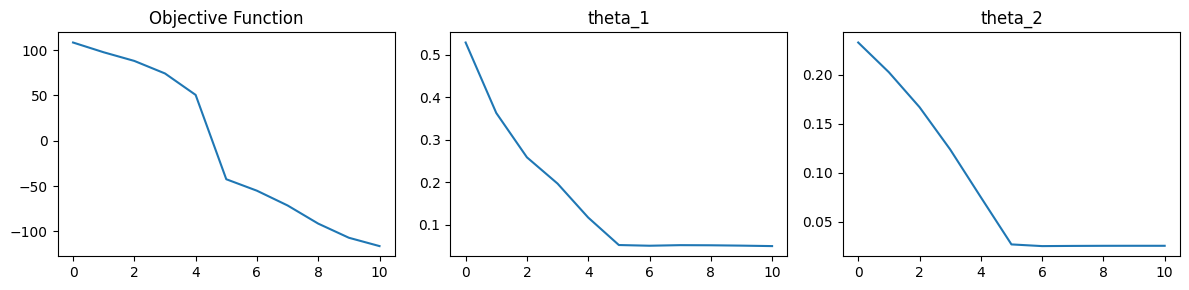

In [20]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=THREE_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list)*0.25)

plot_lc(axes[0], gp_learner.obj_list[begin_at:], 'Objective Function')
plot_lc(axes[1], theta_arr[begin_at:,0], 'theta_1')
plot_lc(axes[2], theta_arr[begin_at:,1], 'theta_2')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'learningCurves.pdf'))

### Final trained parameter values

In [21]:
# extract final trained parameter values
trained_params = gp_learner.params_best.copy()

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'wb') as fp:
    pickle.dump(trained_params, fp)

kernel_params_1
alpha: [13.91179558]
amp: [5.7548159]
ls: [0.56924497 2.86327244]

noise_std: [0.01272151 0.00252478]
theta: [0.04941132 0.02551238]


Can load pre-trained parameters by uncommenting the below

In [22]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [23]:
# posterior mean and covariance over test points
print(f'Posterior results for {GP_TYPE}, Nu/Nf/Nb={Nu}/{Nf}, Ns={test_data.Xs.shape[0]}')
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)
s = jnp.diag(Sigma)**.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, 'u_pred.npy'), mu)
    jnp.save(os.path.join(results_save_dir, 's_pred.npy'), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f'mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}')
savetxt(os.path.join(results_save_dir, 'mean_loss.txt'), abs_losses.mean().reshape(-1,1))

if RUN_INVERSE:
    theta_pred = opt_options['theta_transform'](trained_params['theta'])
    theta_loss = jnp.linalg.norm(theta_pred - THETA_TRUE)
    print(f'theta_true : {THETA_TRUE}')
    print(f'theta_pred : {theta_pred}')
    print(f'theta_loss : {theta_loss:.3e}')
    savetxt(os.path.join(results_save_dir, 'theta_loss.txt'), jnp.array([theta_loss]))

Posterior results for bcgp, Nu/Nf/Nb=25/25, Ns=14400
mean/max loss: 5.781775e-03/1.682e-02
theta_true : [0.05  0.025]
theta_pred : [0.04941132 0.02551238]
theta_loss : 7.804e-04


### Plots of posterior prediction

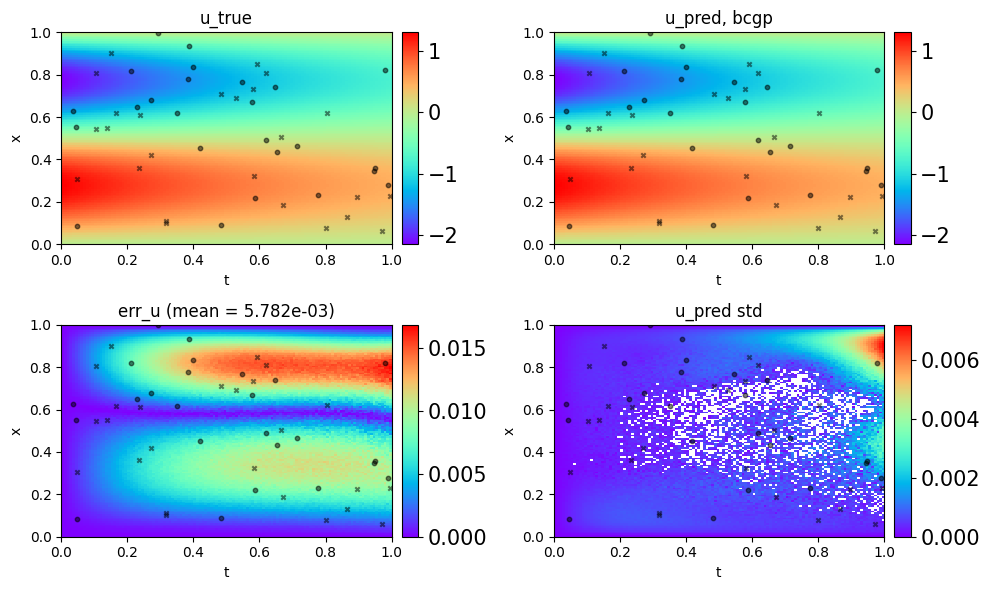

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=TWO_BY_TWO_FIGSIZE)

Nx = len(jnp.unique(test_data.Xs[:,0]))
Nt = len(jnp.unique(test_data.Xs[:,1]))

Xu, Xf = train_data.Xtrain

make_heatmap_ad = lambda ax, output, title=None: make_heatmap(fig, ax, output.reshape(Nt,Nx).T, test_data, Xu, Xf, title)

make_heatmap_ad(axes[0,0], test_data.us, title='u_true')
make_heatmap_ad(axes[0,1], mu, title=f'u_pred, {GP_TYPE}')
make_heatmap_ad(axes[1,0], abs_losses, title=f'err_u (mean = {abs_losses.mean():.3e})')
make_heatmap_ad(axes[1,1], s, title=f'u_pred std')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'posteriorPrediction.pdf'))